In [1]:
project_path = "Z:/Asmara/"
base_atom = "O"
energy_dispersion = 0.00457  # eV/subpixel


In [2]:
%pylab agg
%matplotlib nbagg

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.signal import find_peaks
# from scipy.optimize import curve_fit


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
xas_dict = {}


def load_xas(scan_number, path=project_path.replace("\\", "/"), base=base_atom):

    global xas_dict
    if scan_number not in xas_dict:
        xas = {}
        data = np.loadtxt(f"{path}/XAS/{base}_{scan_number:04d}.xas", comments="#")
        xas["EN"] = data[:, 0]
        xas["TEY"] = data[:, 1]
        xas["TFY"] = data[:, 2]
        xas["RMU"] = data[:, 3]
        xas_dict[scan_number] = xas
    else:
        xas = xas_dict[scan_number]

    return xas["EN"], xas["TEY"], xas["TFY"], xas["RMU"]


In [4]:
rixs_dict = {}


def load_h5(file_name):

    f = h5py.File(file_name, "r")
    ccd = np.array(f["entry"]["analysis"]["spectrum"][()])
    f.close()

    return ccd


def load_ccds(scan_number, path=project_path.replace("\\", "/"), base=base_atom):

    global rixs_dict
    if scan_number not in rixs_dict:
        rixs = {}
        for i in range(1, 4):
            rixs[i] = load_h5(f"{path}/RIXS/{base}_{scan_number:04d}_d{i}.h5")
        rixs_dict[scan_number] = rixs
    else:
        rixs = rixs_dict[scan_number]

    return rixs[1], rixs[2], rixs[3]


In [5]:
def x_corr(refData, uncorrData):

    corr = correlate(refData, uncorrData)
    lag = np.argmax(corr)
    corrData = np.roll(uncorrData, lag)

    return corrData


def elastic_shift(pixelData, zeropixel = None, height=10, width=3, enDisp=energy_dispersion):

    xdataPixel = np.arange(len(pixelData))

    if zeropixel == None:
        #     try to find peak
        peaks, _ = find_peaks(pixelData, height=height, width=width)

        #     try to find peak with right edge
        # peaks = xdataPixel[pixelData>height]
    else:
        peaks = [zeropixel]

    # chop data
    xdataPixel = xdataPixel[(peaks[-1] - 2000) : (peaks[-1] + 200)]
    energyData = pixelData[(peaks[-1] - 2000) : (peaks[-1] + 200)]

    xDataEnergy = (xdataPixel - peaks[-1]) * enDisp

    return xDataEnergy, energyData


def load_rixs(scan_number):

    ccd1, ccd2, ccd3 = load_ccds(scan_number)
    ccd1 = x_corr(ccd2, ccd1)
    ccd3 = x_corr(ccd2, ccd3)

    #    load raw data
    xdata = np.arange(len(ccd2))
    tempdata = ccd1 + ccd2 + ccd3

    #     shift automaticlly
    xdata, tempdata = elastic_shift(tempdata)

    return xdata, tempdata


def load_runs(scans):

    for i, scan_number in enumerate(scans):
        if i == 0:
            xdata, ydata = load_rixs(scan_number)
            refdata = ydata
            sumdata = ydata
        else:
            _, ydata = load_rixs(scan_number)
            ydata = x_corr(refdata, ydata)
            sumdata = sumdata + ydata

    #     normalize data
    # sumdata = sumdata/len(scans)

    return xdata, sumdata


In [6]:
def plot_map(run_list,Y = None):
    run_num = len(run_list)
    data = np.zeros((run_num,2200))
    for i,runs in enumerate(run_list):
        if type(runs) is list:
            X,d = load_runs(runs)
        else:
            X,d = load_runs([runs])
        data[i,:] = d
    if Y is None:
        Y = np.arange(run_num+1)
    else:
        pass
    fig,ax = subplots()
    im = ax.pcolorfast(X,Y,data)
    fig.colorbar(im)
    ax.set_xlabel('Energy Loss ( eV )')
    
    return fig,ax,im
        

## Example to plot XAS data

<IPython.core.display.Javascript object>


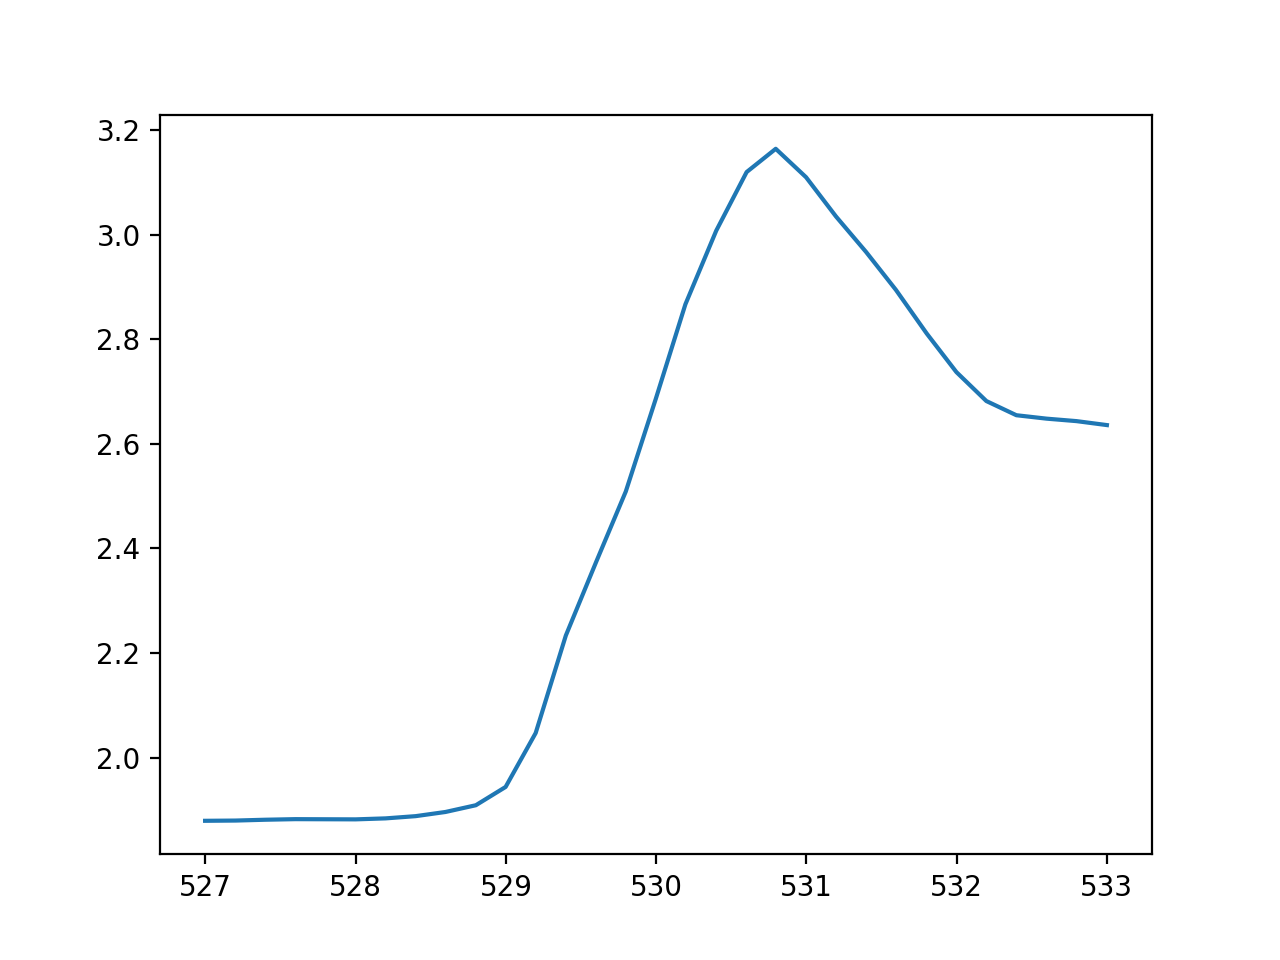

In [7]:
figure()
EN, TEY, TFY, RMU = load_xas(2)
plot(EN, TEY)


## Example to plot one RIXS acquire

<IPython.core.display.Javascript object>


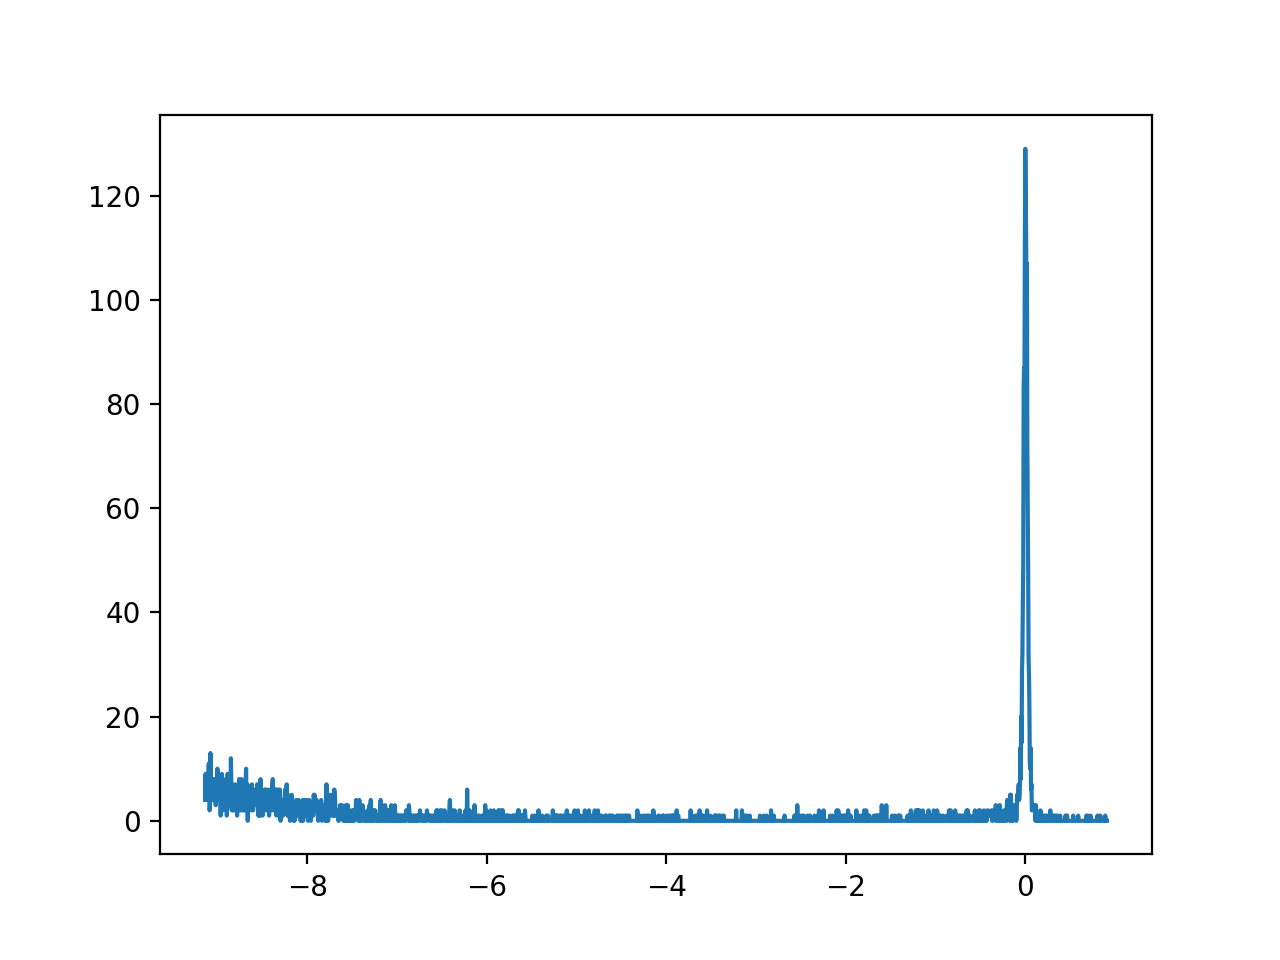

In [8]:
figure()
X, Y = load_rixs(28)
plot(X, Y)


## Example to combine and plot repeating RIXS data

<IPython.core.display.Javascript object>


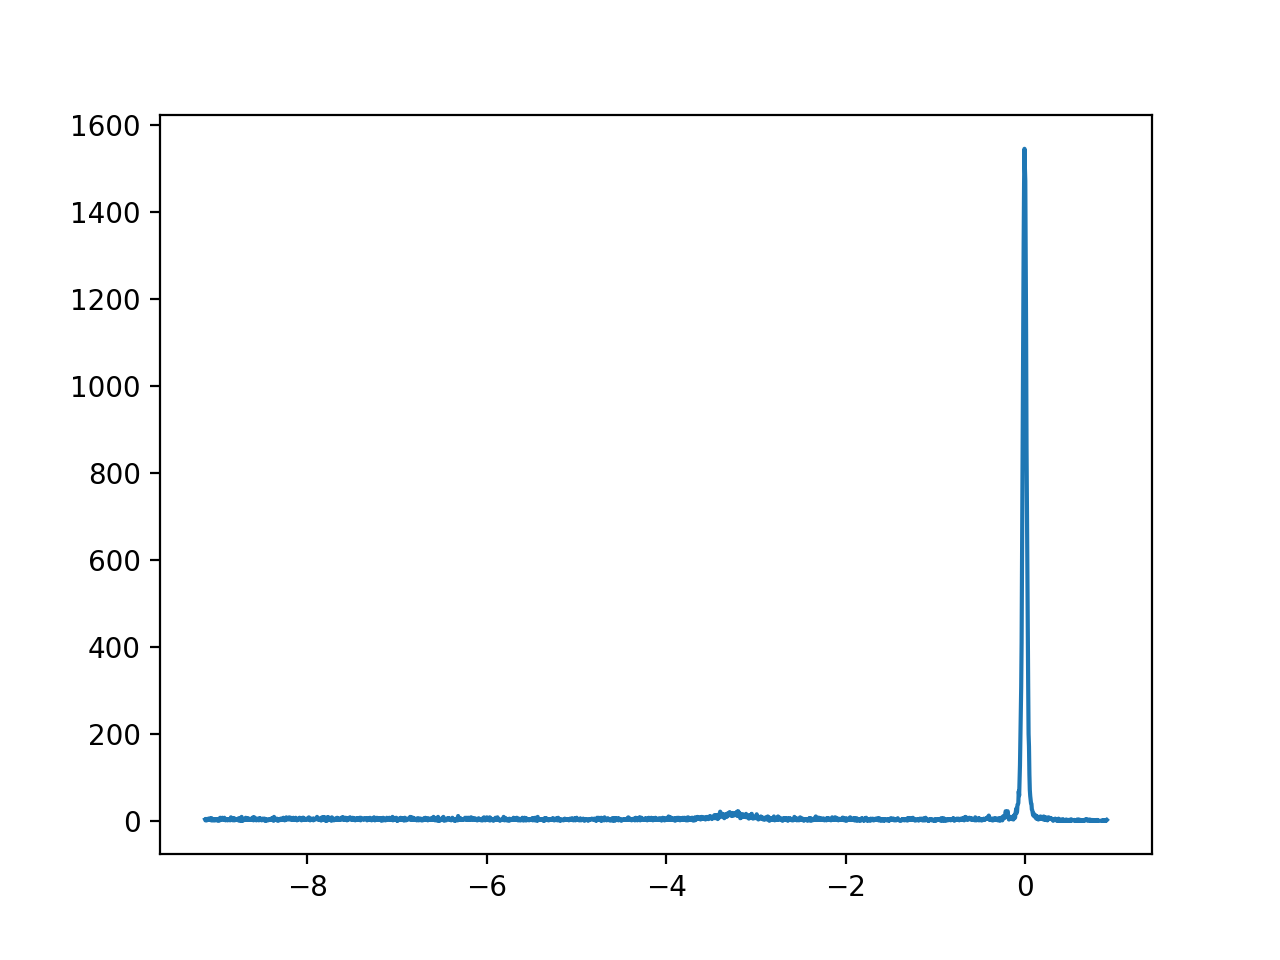

In [9]:
figure()
X, Y = load_runs([18, 19, 20, 21])
plot(X, Y)


<IPython.core.display.Javascript object>


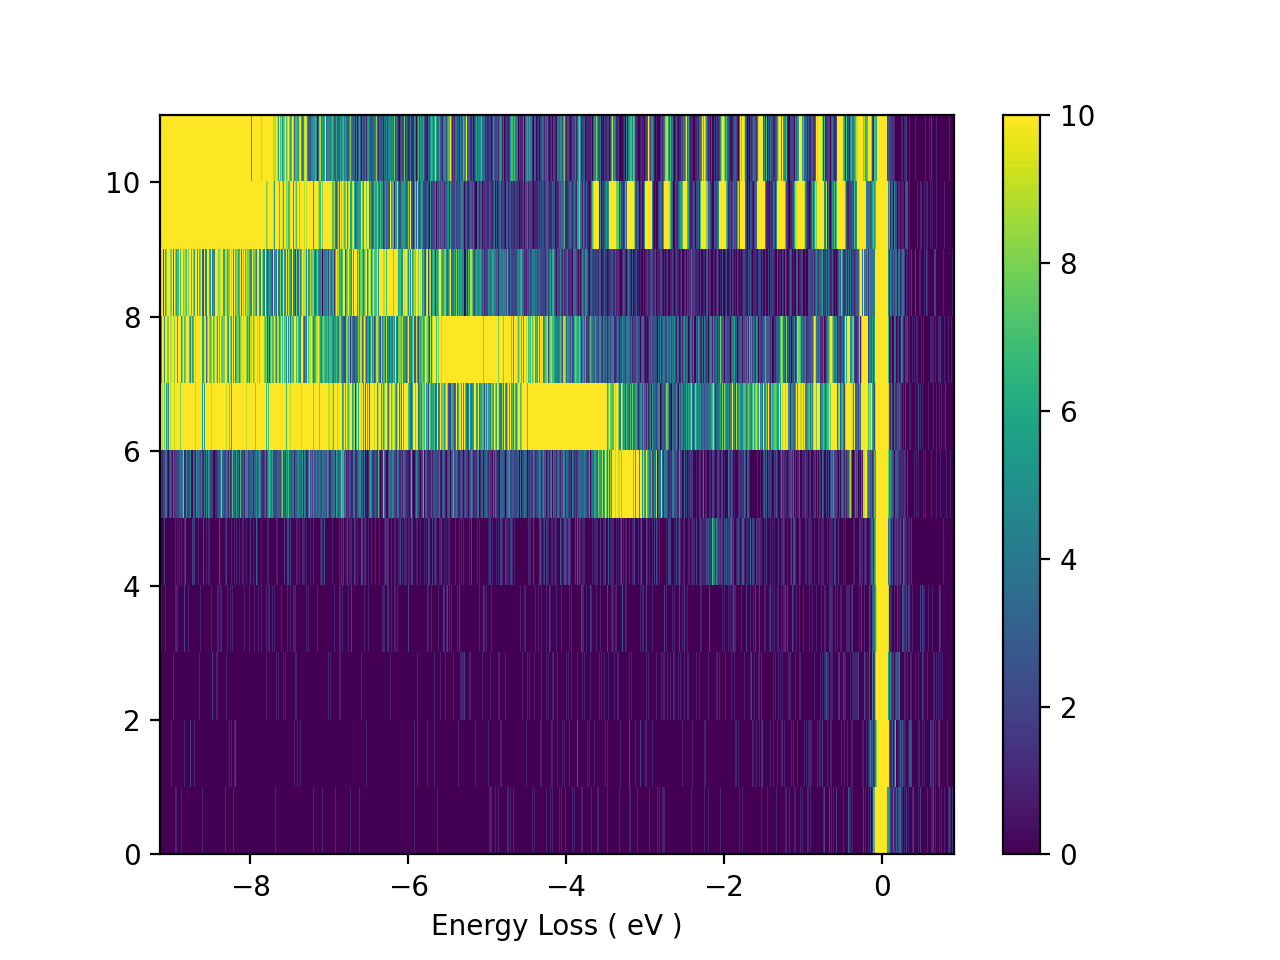

In [10]:
run_list = range(16,26+1)
fig,ax,im = plot_map(run_list)
im.set_clim(0,10)

<IPython.core.display.Javascript object>


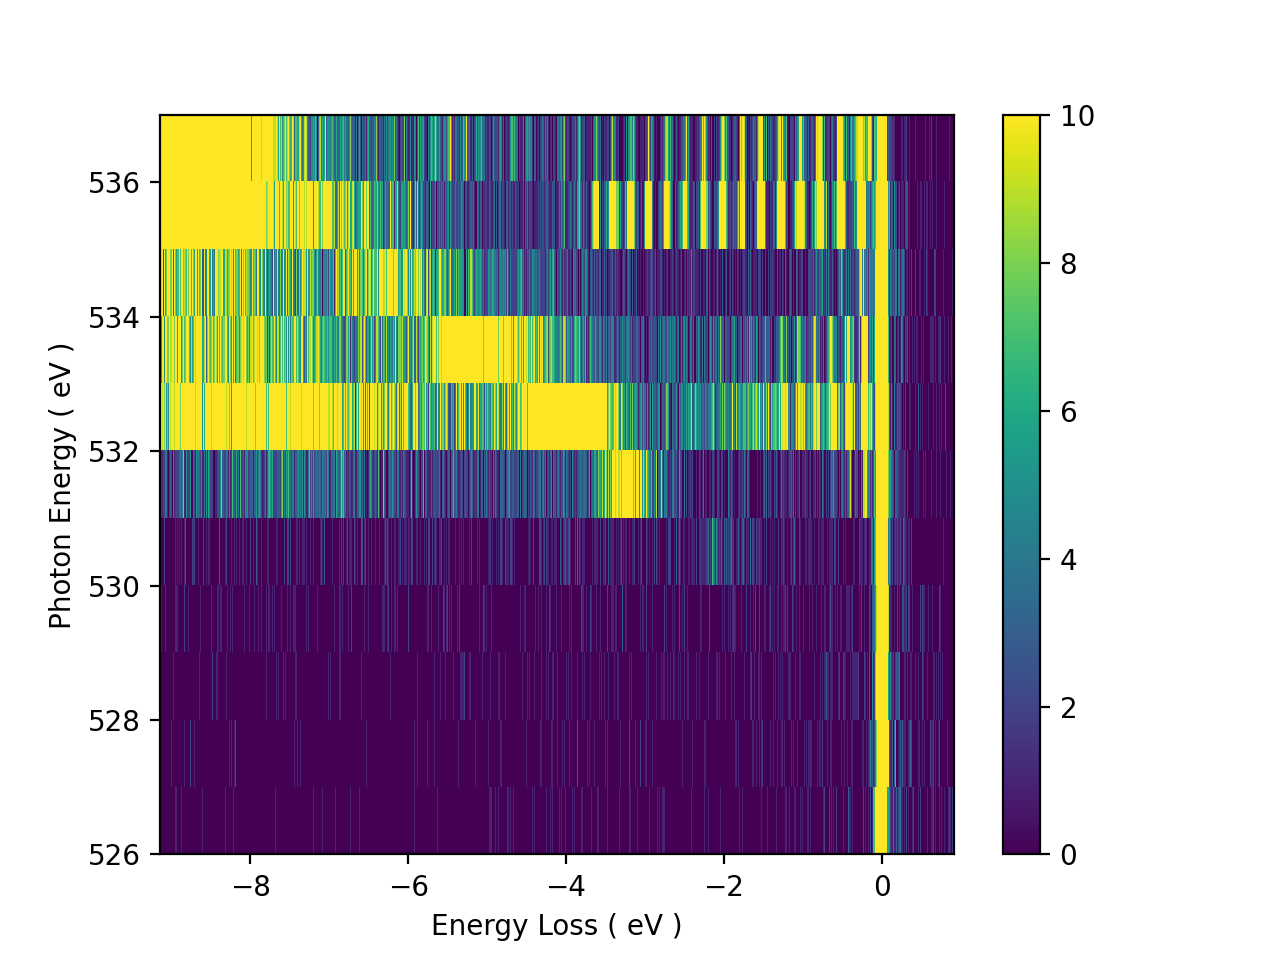

Text(0, 0.5, 'Photon Energy ( eV )')

In [11]:
run_list = range(16,26+1)
fig,ax,im = plot_map(run_list,Y=(526,536+1))
im.set_clim(0,10)
ax.set_ylabel('Photon Energy ( eV )')